In [2]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import os
from osgeo import ogr
import gdal
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import shapely
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon,shape
from shapely.strtree import STRtree  

# hand made functions
from Rouss1 import gp2idomain, gp2cellids, get_heads, get_spdis, get_MNTbbox, import_riv
from Rouss1 import inter_lst,get_cellcenters, lin_interp,ibd_bcdata

flopy is installed in C:\Users\emmal\Anaconda3\lib\site-packages\flopy


In [3]:
model_dir = "working"
model_name = "DIS_Chabart"
exe_name= "../../exe/mf6"

In [4]:
#data paths
sub_c1 = "../data/sub_c1.csv"
sub_c2 = "../data/sub_c2.csv"
sub_c3 = "../data/sub_c3.csv"
ep1 = "../data/sub_ep1.csv"
ep2 = "../data/sub_ep2.csv"
deb_c1 = "../data/prelev_c1.csv"
deb_c2 = "../data/prelev_c2.csv"
deb_c3 = "../data/prelev_c3.csv"
rch_zones = "../data/rch_zone.csv"
topo = "../data/topo.csv"
perma1 = "../data/perma1.csv"
perma2 = "../data/perma2.csv"
perma3 = "../data/perma3.csv"

In [5]:
# spatial parameters
x0 = 620e3
y0 = 3024e3
nlay = 5
nrow = 38
ncol = 42
delr = np.ones(ncol)*1000
delc = np.ones(nrow)*1000


In [6]:
# import surfaces
botm_c1 = pd.read_csv(sub_c1,sep=";",header=None,na_values=None)
botm_c1[botm_c1==7777]=None # remove nodata

botm_c2 = pd.read_csv(sub_c2,sep=";",header=None,na_values=None)
botm_c2[botm_c2==7777]=None # remove nodata

botm_c3 = pd.read_csv(sub_c3,sep=";",header=None,na_values=None)
botm_c3[botm_c3==7777]=None

epo1 = pd.read_csv(ep1,sep=";",header=None,na_values=None)
epo1[epo1>7776]=None # remove nodata

epo2 = pd.read_csv(ep2,sep=";",header=None,na_values=None)
epo2[epo2>7776]=None # remove nodata

top = pd.read_csv(topo,sep=";",header=None)
#top[top==7777]=None # remove nodata
#top[top<0]=10

In [7]:
## assign idomain
idomain_1 = np.zeros([38,42])
idomain_2 = np.zeros([38,42])
idomain_3 = np.zeros([38,42])
idomain_4 = np.zeros([38,42])
idomain_5 = np.zeros([38,42])

idomain_2[(botm_c3.notnull())]=-1
idomain_3[(botm_c3.notnull())]=-1
idomain_4[(botm_c3.notnull())]=-1

idomain_1[botm_c1.notnull()] = 1
idomain_2[epo2.notnull()] = 1
idomain_3[botm_c2.notnull()] = 1
idomain_4[epo1.notnull()] = 1
idomain_5[botm_c3.notnull()] = 1

In [8]:
# create the surfaces
bot1 = top.copy()

bot1[pd.DataFrame(idomain_1!=1)] = top[pd.DataFrame(idomain_1!=1)] - 0.1
bot1[pd.DataFrame(idomain_1==1)] = botm_c1[pd.DataFrame(idomain_1==1)]

bot1.iloc[31,33]=top.iloc[31,33]-1 # bricolage pour corriger qqch

bot2 = bot1.copy()
bot2[pd.DataFrame(idomain_2!=1)] = bot1[pd.DataFrame(idomain_2!=1)]-0.1
bot2[pd.DataFrame(idomain_2==1)] = epo2[pd.DataFrame(idomain_2==1)]

bot2.iloc[31,33]=bot1.iloc[31,33]-1 # bricolage pour corriger 
bot2.iloc[7,23]=bot1.iloc[7,23]-1
bot2.iloc[4,24]=bot1.iloc[4,24]-1

bot3 = bot2.copy()
bot3[pd.DataFrame(idomain_3!=1)] = bot2[pd.DataFrame(idomain_3!=1)]-0.1
bot3[pd.DataFrame(idomain_3==1)] = botm_c2[pd.DataFrame(idomain_3==1)]

bot4 = bot3.copy()
bot4[pd.DataFrame(idomain_4!=1)] = bot3[pd.DataFrame(idomain_4!=1)]-0.1
bot4[pd.DataFrame(idomain_4==1)] = epo1[pd.DataFrame(idomain_4==1)]

bot5 = bot4.copy()
bot5[pd.DataFrame(idomain_5!=1)] = bot4[pd.DataFrame(idomain_5!=1)]-0.1
bot5[pd.DataFrame(idomain_5==1)] = botm_c3[pd.DataFrame(idomain_5==1)]

In [9]:
idomain=np.ones([nlay,nrow,ncol])
idomain[0,:,:]=idomain_1
idomain[1,:,:]=idomain_2
idomain[2,:,:]=idomain_3
idomain[3,:,:]=idomain_4
idomain[4,:,:]=idomain_5

bot = np.ones([nlay,nrow,ncol])
bot[0,:,:]=bot1
bot[1,:,:]=bot2
bot[2,:,:]=bot3
bot[3,:,:]=bot4
bot[4,:,:]=bot5
bot[bot>1000]=150

In [10]:
sim = fp.mf6.MFSimulation(sim_name='theis_mf6', version='mf6', exe_name=exe_name, 
                             sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top.values, botm=bot,xorigin=x0,yorigin=y0,idomain=idomain)
tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])


ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity='simple')

# initial conditions
ic   = fp.mf6.ModflowGwfic(gwf)

# nodeflowproperty
kh = 1e-4
npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=kh, save_flows=True,save_specific_discharge=True)


In [11]:
file_bot = "working/bot"
np.save(file_bot,bot)

file_top = "working/top"
np.save(file_top,top.values)

file_idom = "working/idomain"
np.save(file_idom,idomain)

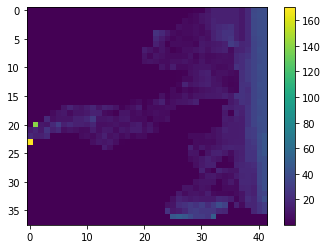

In [12]:
plt.imshow(top-bot1)
plt.colorbar()

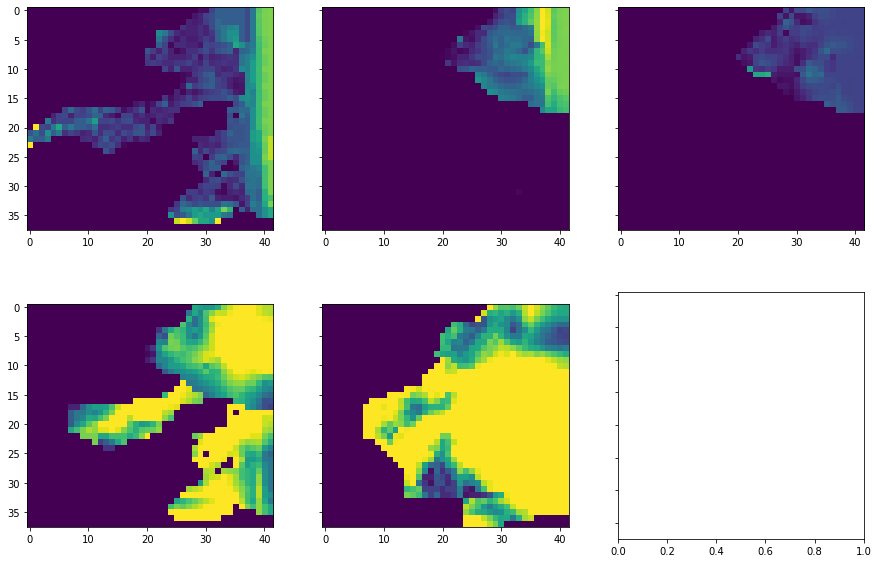

In [13]:
surface = [top,bot1,bot2,bot3,bot4,bot5]
fig,ax = plt.subplots(2,3,sharey=True,figsize=(15,10))
i=0;l=0
for s in np.arange(len(surface)-1):
    b=ax[l,i].imshow(surface[s]-surface[s+1])
    b.set_clim(0,50)
    i +=1
    if i == 3:
        i=0
        l+=1

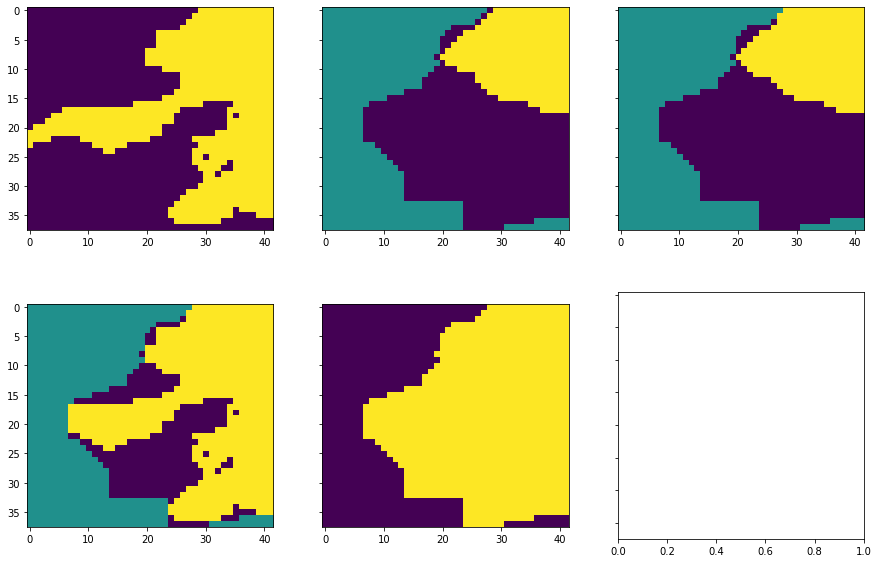

In [21]:
surface = [idomain_1,idomain_2,idomain_3,idomain_4,idomain_5]
fig,ax = plt.subplots(2,3,sharey=True,figsize=(15,10))
i=0;l=0
for s in surface:
    b=ax[l,i].imshow(s)
    i +=1
    if i == 3:
        i=0
        l+=1


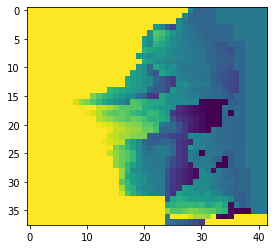

In [15]:
im=plt.imshow(top)
im.set_clim(-50,100)

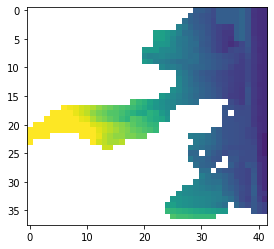

In [16]:
im=plt.imshow(botm_c1)
im.set_clim(-50,100)